# 分類

### Q1. K近傍法（1/2）
**K近傍法**は，機械学習による分類モデルの中でも最も単純なものである．ラベルが未知のデータ（入力データ）が与えられたとき，K近傍法は以下の手順で入力データのラベルを予測する．
1. すべての既知データに対して，入力データとの距離を計算する．
2. 距離が近い上位K件の既知データのラベルを調べる
3. ステップ2で最も数が多かったラベルを入力データのラベルとする．

下図は``data/blobs/sample1.tsv``ファイルに格納されたデータの散布図である．図が示すとおり，ファイルにはラベル0とラベル1が割り当てられたデータが格納されている．データの75%を既知データ（25%は未知データ）と見なして，未知の2次元データのラベルを2値分類するK近傍法を実装せよ．

In [3]:
from sklearn.datasets import make_blobs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set()
sns.set_style('ticks')
%matplotlib inline

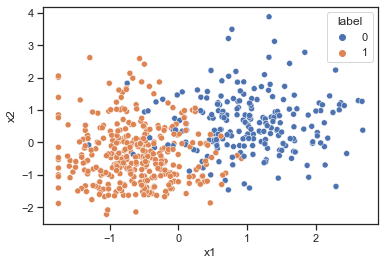

In [3]:
sample_df = pd.read_table('../data/blobs/sample1.tsv', header=0, sep='\t')

sns.scatterplot(x='x1', y='x2', hue='label', data=sample_df)
plt.show()

In [4]:
split_idx = int(len(sample_df)*0.75)
smpl = sample_df.sample(frac=1)
known_data = smpl[:split_idx]
unknown_data = smpl[split_idx:]

In [5]:
import math
import statistics

def knn(target: iter, k: int) -> str:
    euclid_distance = lambda data, target:math.sqrt( (target[2]-data[2])**2 + (target[3]-data[3])**2 )
    distances = [(known[1], euclid_distance(known, target)) for known in known_data.itertuples()]
    sorted_dist = sorted(distances, key=lambda x:x[1])
    return statistics.mode(list(map(lambda x:x[0], sorted_dist[:5])))

### Q2. K近傍法（2/2）：分類性能の評価
実装したK近傍法を，Q1で用意した25%の未知データ（評価データ）に適用し，評価データのラベルを推定せよ．その結果を用いて，実装したK近傍法の分類性能を評価せよ．なお，評価基準は以下とする．

* 精度（Accuracy）
* 適合率（Precision）
* 再現率（Recall）
* F1値（F1）

In [6]:
mapp = lambda func, *iters: list(map(func, *iters))
fillter = lambda func, *iters: list(filter(func, *iters))

In [7]:
preds = [ (knn(data, 5), (data[2], data[3])) for data in unknown_data.itertuples()]

予測されたラベル

| - | 1 | 0 |
|--|---|---|
|1|真陽性(正解)|偽陰性(間違い)|   実際の
|0|偽陽性(間違い)|真陰性(正解)|   ラベル

In [8]:
errata = [ 1 if valid[1] == pred[0] else 0 for valid, pred in zip(unknown_data.itertuples(), preds)]
accuracy = sum(errata) / len(unknown_data)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9230769230769231


In [9]:
true_positive = fillter(lambda x:x[0][0]==1 and x[1]==1, zip(preds, errata))
pred_positive = fillter(lambda x:x[0]==1, preds)
precision = len(true_positive) / len(pred_positive)
print(f'Precision: {precision}')

Precision: 0.9146341463414634


In [10]:
true_positive = fillter(lambda x:x[0][0]==1 and x[1]==1, zip(preds, errata))
actual_positive = fillter(lambda x:x[1]==1, unknown_data.itertuples())
recall = len(true_positive) / len(actual_positive)
print(f'Recall: {recall}')

Recall: 0.9493670886075949


In [11]:
f1 = 2*(precision*recall) / (precision + recall)
print(f'F1: {f1}')

F1: 0.9316770186335404


### Q3. ロジスティック回帰（1/2）
K近傍法に代表される**インスタンスベースの学習器**は，シンプルなため適用範囲が広い．一方で，未知データが入力される度に既知データとの未知データの距離を計算する必要があり，予測にかかるコストが大きい．一方で，ロジスティック回帰やサポートベクターマシンのような**モデルベースの学習器**は，モデル構築には時間がかかるが，一旦モデルが構築されれば予測は比較的高速に行えるというメリットがある．

Q1で用いたデータとロジスティック回帰を用いて，未知の2次元データをラベル0とラベル1に分類するモデルを構築せよ．さらに，5分割交差検証法を用いて，モデルの分類性能を評価せよ．なお，評価基準は下記を用いよ．

* 精度（Accuracy）
* 適合率（Precision）
* 再現率（Recall）
* F1値（F1）
* AUC（Area under the ROC Curve）

ROC曲線  : 縦軸に真陽性率，横軸に偽陽性率を取りプロットした曲線．  
AUC     : ROC曲線の下側の面積をAUCと呼び， 0 < AUC < 1 ,1に近いほど判別能が高い

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

lr = LogisticRegression()
x_train = known_data.loc[:, ['x1', 'x2']]
y_train = known_data['label']
x_test = unknown_data.loc[:, ['x1', 'x2']]
y_test = unknown_data['label']

In [13]:
scoring = [
    'accuracy',
    'precision',
    'recall',
    'f1',
    'roc_auc'
]

scores = cross_validate(lr, x_train, y_train, cv=5, scoring=scoring, return_estimator=True)
scores
for scoring, score in scores.items():
    if scoring != 'estimator':
        print(f'{scoring} \t: {score.mean()}')

fit_time 	: 0.006017065048217774
score_time 	: 0.008071660995483398
test_accuracy 	: 0.9085088919288646
test_precision 	: 0.9202284752284753
test_recall 	: 0.9425974025974024
test_f1 	: 0.930779512840982
test_roc_auc 	: 0.9743475891924168


In [14]:
models = scores['estimator']

### Q4. ロジスティック回帰（2/2）
下図は``data/blobs/sample2.tsv``ファイルに格納されたデータの散布図である．図が示すとおり，ファイルにはラベル0とラベル1が割り当てられたデータが格納されている．当該ファイルとロジスティック回帰を用いて，未知の2次元データを精度（accuracy）90%以上でラベル0とラベル1に分類するモデルを構築せよ．なお，性能評価には交差検証法を用いよ．

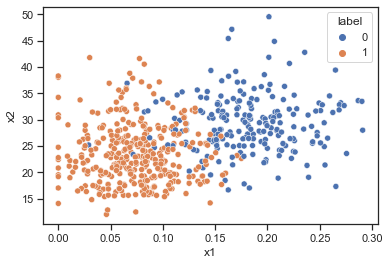

In [15]:
sample2_df = pd.read_table('../data/blobs/sample2.tsv', header=0, sep='\t')

sns.scatterplot(x='x1', y='x2', hue='label', data=sample2_df)
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate

smpl2 = sample2_df.sample(frac=1)
split_idx = int(len(sample_df)*0.75)
known_data = smpl2[:split_idx]
unknown_data = smpl2[split_idx:]
x_train = known_data.loc[:, ['x1', 'x2']]
y_train = known_data['label']
x_test = unknown_data.loc[:, ['x1', 'x2']]
y_test = unknown_data['label']

In [17]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'C': [0.1, 1.0, 10],
    # 'n_jobs': [6]
}

lr = LogisticRegression(C=0.1, penalty='none', solver='newton-cg')

scoring = [
    'accuracy'
]

scores = cross_validate(lr, x_train, y_train, cv=5, scoring=scoring, return_estimator=True)
preds = scores['estimator'][0].predict(x_test).tolist()
print('Cross validation')
for scoring, score in scores.items():
    if scoring != 'estimator':
        print(f'\t{scoring} \t: {score.mean()}')

errata = [ 1 if valid[1] == pred else 0 for valid, pred in zip(unknown_data.itertuples(), preds)]
accuracy = sum(errata) / len(unknown_data)
print(f'Test data\n\tAccuracy: {accuracy}')

Cross validation
	fit_time 	: 0.026013612747192383
	score_time 	: 0.002445030212402344
	test_accuracy 	: 0.9060191518467852
Test data
	Accuracy: 0.916083916083916


### Q5. Imbalanced Data（1/3）：層化K分割交差検証
下図は``data/blobs/sample3.tsv``ファイルに格納されたデータの散布図である．ファイルにはラベル0とラベル1が割り当てられたデータが格納されている．図が示しているように，ラベル0とラベル1でデータ数に偏りがある．

「モデル構築と評価」に記したコードは，``sample3.tsv``ファイルのデータとロジスティック回帰を用いて，2次元データの2値分類を行う分類器の構築と評価を行うコードの例である．このコードは分類器の評価を行う上で問題がある．その問題点を指摘し，コードを改善せよ．

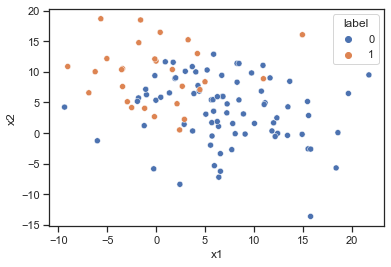

In [18]:
sample3_df = pd.read_table('../data/blobs/sample3.tsv', header=0, sep='\t')

sns.scatterplot(x='x1', y='x2', hue='label', data=sample3_df)
plt.show()

##### モデル構築と評価

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
# Additonal
from sklearn.model_selection import StratifiedKFold

# データ準備
X = sample3_df.drop('label', axis=1).values
y = sample3_df['label'].values

# K-Fold で汎化性能を評価する
# k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
# Use stratified K-Fold keep refrain from biased training data
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# 評価指標
score_funcs = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# モデル定義
clf = LogisticRegression()

# Cross Validation で検証する
scores = cross_validate(clf, X, y, cv=k_fold, scoring=score_funcs)

# 評価結果を出力する
print("Accuracy =", np.mean(scores['test_accuracy']))
print("Precision =", np.mean(scores['test_precision']))
print("Recall =", np.mean(scores['test_recall']))
print("F1 =", np.mean(scores['test_f1']))
print("AUC =", np.mean(scores['test_roc_auc']))

Accuracy = 0.8424242424242424
Precision = 0.7261904761904762
Recall = 0.6
F1 = 0.648997668997669
AUC = 0.86875


### Q6. Imbalanced Data（2/3）：評価指標の考察
Q5で用いたデータのように，分類するラベルの分布に偏りがあるデータは**不均衡データ**と呼ばれる．不均衡データに対する分類器の性能評価では，評価指標として精度（accuracy）を用いることは適切ではない．その理由を下記混同行列（confusion matrix）を用いて説明せよ．また，不均衡データに対する分類器の評価指標として，適切なものを調査せよ．

||実際に正例であるデータ|実際に負例であるデータ|合計|
|:---:|:---:|:---:|:---:|
|分類器が正解としたデータ|81|9|90|
|分類器が不正解としたデータ|9|1|10|
|合計|90|10|100|

上記の混同行列のように負例であるデータが極端に少ない場合，仮にすべての入力に対し「正解」と予測した場合にも精度（accuracy）は90%となる．しかしこのモデルは「不正解」のデータを全く予測できないため，分類予測モデルとしては適切でない．このように精度のみでモデルを評価することは適切でない場合が存在する．このような場合，モデルに求める性能により適切な評価指標を用いる必要がある．  
本来は「**不正解**」であるのにも関わらず「**正解**」と判断されることを防ぎたい場合は，分類器が「正解」/「不正解」であると分類したもののうち，実際に「正解」/「不正解」であった割合を表す適合率（precision）を用いるのが適切である．本来は「**正解**」であるのにも関わらず「**不正解**」と判断されることを防ぎたい場合は，実際に「正解」/「不正解」であるものをどれだけ正しく予測することができたかを表す再現率（recall）を用いるのが適切である．

### Q7. Imbalanced Data（3/3）：Over/under sampling
Q5で用いたデータは，ラベル0とラベル1でデータ数に偏りがある．ラベル1のデータ数はラベル0のデータ数に比べて大幅に数が少ない．このように偏ったデータをそのまま学習に使用すると，性能の高い分類器を構築することができない．

このような学習・評価データの偏りの問題を解決するために，データの偏りを補正するアンダーサンプリングやオーバーサンプリングという方法が提案されている．**アンダーサンプリング**は，少数派データの件数に合うように多数派データからランダムにデータを抽出するというものである．**オーバーサンプリング**は，少数派のデータの特徴を踏まえて擬似的なデータを生成し，多数派データの件数に合うよう少数派のデータを増やすものである．

Q5で用いたデータに対して，オーバーサンプリングもしくはアンダーサンプリングを行い，新たに得られたデータに対して（Q5と同様の）ロジスティック回帰による学習・評価を行え．

なお，Pythonでオーバー/アンダーサンプリングを行うライブラリとしては``imbalanced-learn``等がある．

In [20]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X = sample3_df.drop('label', axis=1).values
y = sample3_df['label'].values

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(X, y)
x_rus, y_rus = rus.fit_resample(X, y)

print(f'Over resampled dataset\t: {Counter(y_ros)}')
print(f'Under resampled dataset\t: {Counter(y_rus)}')


Over resampled dataset	: Counter({0: 80, 1: 80})
Under resampled dataset	: Counter({0: 28, 1: 28})


In [21]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
clf = LogisticRegression()
scores_ros = cross_validate(clf, x_ros, y_ros, cv=k_fold, scoring=scoring)
scores_rus = cross_validate(clf, x_rus, y_rus, cv=k_fold, scoring=scoring)

print('|===== Over sampling =====|')
print("Accuracy =", np.mean(scores_ros['test_accuracy']))
print("Precision =", np.mean(scores_ros['test_precision']))
print("Recall =", np.mean(scores_ros['test_recall']))
print("F1 =", np.mean(scores_ros['test_f1']))
print("AUC =", np.mean(scores_ros['test_roc_auc']))

print('|===== Under sampling =====|')
print("Accuracy =", np.mean(scores_rus['test_accuracy']))
print("Precision =", np.mean(scores_rus['test_precision']))
print("Recall =", np.mean(scores_rus['test_recall']))
print("F1 =", np.mean(scores_rus['test_f1']))
print("AUC =", np.mean(scores_rus['test_roc_auc']))

|===== Over sampling =====|
Accuracy = 0.74375
Precision = 0.7515966386554622
Recall = 0.7372508423659319
F1 = 0.7314165497896213
AUC = 0.8794905208460196
|===== Under sampling =====|
Accuracy = 0.7696969696969698
Precision = 0.7350000000000001
Recall = 0.7028571428571428
F1 = 0.7138461538461539
AUC = 0.8703968253968254


### Q8. 線形分離不可能問題（1/2）：高次元空間へのデータ写像
下図は変数``moons``に格納された2次元データの散布図である．図が示しているように，``moons``に格納されたデータは線形分離不可能である．そのため，一般的なロジスティック回帰モデルでは，``moons``のデータ分布傾向に従うデータの分類を行うのは困難である．

一方，``moons``に格納されたデータを高次元空間に写像することで，ロジスティック回帰モデルでもラベルの分類が可能になる．``moons``に格納された2次元データに特徴量を追加することで，ロジスティック回帰モデルでも分類精度（accuracy）が90%を超えるようにせよ．

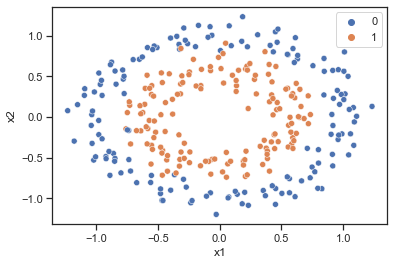

In [22]:
from sklearn.datasets import make_circles, make_moons
moons = make_circles(n_samples=300, noise=0.1, factor=0.6, random_state=777)

X = moons[0]
y = moons[1]

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

In [23]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2)
pf_X = pf.fit_transform(X)
# [1. , x1, x2, x1^2, x1*x2, x2^2]


In [24]:
# x1, x2, x1^2
X_pf1 = pf_X[:, [False, True, True, True, False, False]]
X_pf2 = pf_X[:, [False, True, True, False, False, True]]
X_pf3 = pf_X[:, [False, True, True, False, True, False]]
X_pf4 = pf_X[:, [False, True, True, True, False, True]]
X_pf5 = pf_X[:, [False, True, True, True, True, False]]
X_pf6 = pf_X[:, [False, True, True, False, True, True]]
X_pf7 = pf_X[:, [False, True, True, True, True, True]]
X_2 = np.power(X, 2)
X_2_sum = np.sum(X_2, axis=1)
X_pf8 = np.insert(X, 2, X_2_sum, axis=1)

In [25]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
clf = LogisticRegression()
scores_pf1 = cross_validate(clf, X_pf1, y, cv=k_fold, scoring=scoring)
scores_pf2 = cross_validate(clf, X_pf2, y, cv=k_fold, scoring=scoring)
scores_pf3 = cross_validate(clf, X_pf3, y, cv=k_fold, scoring=scoring)
scores_pf4 = cross_validate(clf, X_pf4, y, cv=k_fold, scoring=scoring)
scores_pf5 = cross_validate(clf, X_pf5, y, cv=k_fold, scoring=scoring)
scores_pf6 = cross_validate(clf, X_pf6, y, cv=k_fold, scoring=scoring)
scores_pf7 = cross_validate(clf, X_pf7, y, cv=k_fold, scoring=scoring)
scores_pf8 = cross_validate(clf, X_pf8, y, cv=k_fold, scoring=scoring)

print('|===== x_1, x_2, x_1^2 =====|')
print("Accuracy =", np.mean(scores_pf1['test_accuracy']), '\n')

print('|===== x_1, x_2, x_2^2 =====|')
print("Accuracy =", np.mean(scores_pf2['test_accuracy']), '\n')

print('|===== x_1, x_2, x_1*x_2 =====|')
print("Accuracy =", np.mean(scores_pf3['test_accuracy']), '\n')

print('|===== x_1, x_2, x_1^2, x_2^2 =====|')
print("Accuracy =", np.mean(scores_pf4['test_accuracy']), '\n')

print('|===== x_1, x_2, x_1^2, x_1*x_2 =====|')
print("Accuracy =", np.mean(scores_pf5['test_accuracy']), '\n')

print('|===== x_1, x_2, x_1*x_2, x_2^2 =====|')
print("Accuracy =", np.mean(scores_pf6['test_accuracy']), '\n')

print('|===== x_1, x_2, x_1^2, x_1*x_2, x_2^2 =====|')
print("Accuracy =", np.mean(scores_pf7['test_accuracy']), '\n')

print('|===== x_1, x_2, x_1^2+x_2^2 =====|')
print("Accuracy =", np.mean(scores_pf8['test_accuracy']), '\n')


|===== x_1, x_2, x_1^2 =====|
Accuracy = 0.6866666666666666 

|===== x_1, x_2, x_2^2 =====|
Accuracy = 0.6833333333333333 

|===== x_1, x_2, x_1*x_2 =====|
Accuracy = 0.3866666666666667 

|===== x_1, x_2, x_1^2, x_2^2 =====|
Accuracy = 0.9633333333333333 

|===== x_1, x_2, x_1^2, x_1*x_2 =====|
Accuracy = 0.6866666666666666 

|===== x_1, x_2, x_1*x_2, x_2^2 =====|
Accuracy = 0.6766666666666666 

|===== x_1, x_2, x_1^2, x_1*x_2, x_2^2 =====|
Accuracy = 0.9633333333333333 

|===== x_1, x_2, x_1^2+x_2^2 =====|
Accuracy = 0.9633333333333333 



### Q9. 線形分離不可能問題（2/2）：非線形SVM
Q8で扱った``moons``データについて，（特徴量を新規に追加せず）元の特徴量データを用いても精度90%以上でラベルの分類が可能な分類器を，サポートベクターマシン（SVM）を用いて構築せよ．

In [26]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=0.1, gamma=1)
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
scores_svc = cross_validate(svc, X, y, cv=k_fold, scoring=scoring)
print("Accuracy =", np.mean(scores_svc['test_accuracy']))

Accuracy = 0.9633333333333333


### Q10. Kickstarterのプロジェクトデータの準備
[Kickstarter](http://www.kickstarter.com/)は，最も著名なクラウドファンディングサイトの1つであり，ガジェット，音楽など，様々なカテゴリのプロジェクトに関する資金調達が日々行われている．Kickstarterでは，プロジェクト企画者はプロジェクトの説明とともに資金の調達期限と目標最小金額を設定し，一般大衆から投資を募る．期限までに目標最小金額に達すれば資金を全額得られるが，達しなければ1円も資金を得ることができない．

データ分析コンペサイトである[Kaggle](https://www.kaggle.com/)には，過去にKickstarterで起ち上げられた資金調達プロジェクトの成否に関するデータが公開されている．本課題では，この公開データを用いて，**Kickstarterで起ち上げられるプロジェクトの資金調達の成否を予測するモデル**を構築することを検討する．

[データ公開URL](https://www.kaggle.com/kemical/kickstarter-projects/download)より，Kickstarterのプロジェクトデータをダウンロードし，ダウンロードしたデータファイルに格納された``ks-projects-201801.csv``ファイルの内容を，``pandas``データフレームに格納せよ（留意事項：データのダウンロードには，Kaggleアカウント（無料）が必要になる）．

In [4]:
kickstarter_df = pd.read_table('../data/ks-projects/ks-projects-201801.csv', header=0, sep=',')

### Q11.探索的データ解析
Q10で用意したデータフレームを``kickstarter_df``と呼ぶことにする．``kickstarter_df``には，下記の情報が含まれている．

* ``ID``：プロジェクトのID
* ``name``：プロジェクト名
* ``main_category``：プロジェクトのメインカテゴリ（例：Games）
* ``category``：プロジェクトのカテゴリ（例：Tabletop Games）
* ``currency``：通貨の種類（例: USD = ドルで投資を募る）
* ``deadline``：募集締切日
* ``goal``：目標金額
* ``launched``：募集開始日
* ``pledged``：締切までに集まった資金の額
* ``state``：目標金額に達したか否か（successful, failed, canceled, live, suspended, or undefined）
* ``backers``：締切までに出資者の数
* ``country``：プロジェクトが企画された国
* ``usd pledged``：集まった資金の米ドル換算額（Kickstarterサイトが換算したもの）
* ``usd_predged_real``：集まった資金の米ドル換算額（別サイトで換算したもの）
* ``usd_goal_real``：目標金額の米ドル換算額

資金調達の成否に関わる特徴量は``state``であるが，データには資金調達に成功（successful）もしくは失敗（failed）したプロジェクト以外も含まれる．Q10で用意したデータから資金調達に成功/失敗したプロジェクトのみのデータを取り出し，別のデータフレームに格納せよ．また，新たに格納したデータフレームを用いて，メインカテゴリ毎のプロジェクト数，資金調達成功率を求めよ．さらに目標額の分布について調べよ．

In [5]:
kickstarter_df2 = kickstarter_df.loc[(kickstarter_df['state']=='successful') | (kickstarter_df['state']=='failed')]

In [6]:
kickstarter_df2

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,Food,USD,2017-04-19,6500.0,2017-03-20 22:08:22,154.0,failed,4,US,0.0,154.0,6500.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00


In [7]:
kickstarter_df2['main_category'].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [8]:
ks_success_df = kickstarter_df.loc[kickstarter_df['state']=='successful']
ks_success_df['main_category'].value_counts() / kickstarter_df2['main_category'].value_counts()

Art             0.448890
Comics          0.591415
Crafts          0.270530
Dance           0.654352
Design          0.415944
Fashion         0.282832
Film & Video    0.417906
Food            0.275914
Games           0.438905
Journalism      0.243914
Music           0.526606
Photography     0.341108
Publishing      0.347017
Technology      0.237856
Theater         0.637961
Name: main_category, dtype: float64

<AxesSubplot:>

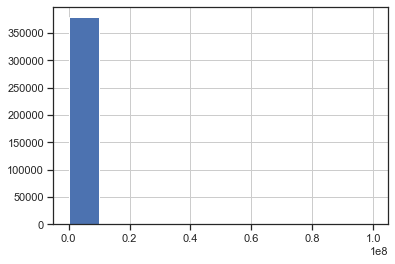

In [9]:
kickstarter_df['goal'].hist()

### Q12. Data Leakage
本来予測には利用できない，あるいは使うことが想定されていない（予測に有用な）データが学習データに含まれている状態を **データリーク（data leakage）** と呼ぶ．

Q11で準備したデータフレームは，資金調達の成否を予測するモデルを構築する上でデータリークが起きている．Q11で用意したデータフレームからデータリークを引き起こしている特徴量（列）を取り除け．

In [10]:
kickstarter_df3 = kickstarter_df2.drop(['state', 'pledged', 'usd pledged', 'usd_pledged_real', 'backers'], axis=1)

In [11]:
kickstarter_df3

,ID,name,category,main_category,currency,deadline,goal,launched,country,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,GB,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,US,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,US,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,US,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,US,50000.00
...,...,...,...,...,...,...,...,...,...,...
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,Food,USD,2017-04-19,6500.0,2017-03-20 22:08:22,US,6500.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,US,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,US,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,US,15000.00


### Q13. 特徴量エンジニアリング
分類モデル構築のために，Q12で用意したデータに対して前処理を実行せよ．

In [12]:
kickstarter_df3.drop(['ID', 'name', 'usd_goal_real'], axis=1, inplace=True)

In [13]:
from datetime import datetime

def get_period(row):
    deadline = datetime.strptime(row[1]['deadline'], '%Y-%m-%d')
    launched = datetime.strptime(row[1]['launched'], '%Y-%m-%d %H:%M:%S')
    return datetime.timestamp(deadline) - datetime.timestamp(launched)

periods = list(map(get_period, kickstarter_df3.iterrows()))

In [14]:
kickstarter_df3['periods'] = periods
kickstarter_df3.drop(['deadline', 'launched'], axis=1, inplace=True)

In [15]:
kickstarter_df_processed = pd.get_dummies(kickstarter_df3, columns=['category', 'main_category', 'currency', 'country'])

In [16]:
kickstarter_df_processed

,goal,periods,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1000.0,5053652.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,5166963.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,3886750.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,2579749.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,2974893.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,6500.0,2512298.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378657,1500.0,2319886.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378658,15000.0,3903570.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
378659,15000.0,2612767.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Q14. 分類モデルの構築
Q13で前処理を行ったデータと決定木ベースの機械学習モデルを用いて，Kickstarterで起ち上げられるプロジェクトの資金調達の成否をAUCスコア0.7以上で予測するモデルを構築せよ．AUCスコアが基準を満たさない場合は，Q13の特徴量エンジニアリングやハイパーパラメータを再考せよ．

なお，モデルの評価は5分割交差検証法で行うこと．また，評価指標はAUCとする．

In [17]:
from sklearn.model_selection import cross_validate

In [55]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(criterion='gini', max_features='sqrt', min_samples_split=100)
scoring = {'roc_auc'}
state = [1 if st == 'successful' else 0 for st in kickstarter_df2['state']]
scores_tree = cross_validate(clf, kickstarter_df_processed, state, cv=5, scoring=scoring, return_estimator=True)

In [56]:
scores_tree

{'fit_time': array([1.50102901, 1.64236879, 1.55675101, 1.71624613, 1.69122314]),
 'score_time': array([0.12452412, 0.12469912, 0.12346625, 0.12473869, 0.12458682]),
 'estimator': (DecisionTreeClassifier(max_features='sqrt', min_samples_split=100),
  DecisionTreeClassifier(max_features='sqrt', min_samples_split=100),
  DecisionTreeClassifier(max_features='sqrt', min_samples_split=100),
  DecisionTreeClassifier(max_features='sqrt', min_samples_split=100),
  DecisionTreeClassifier(max_features='sqrt', min_samples_split=100)),
 'test_roc_auc': array([0.70344037, 0.7021067 , 0.70514887, 0.7027758 , 0.70324762])}

### Q15. 分類に寄与する特徴量
Q14で構築した分類器において，Kickstarterロジェクトの資金調達の成否を予測する上で有用と評価された特徴量（属性）を20個表示せよ．

In [66]:
feature_importance = scores_tree['estimator'][0].feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

In [80]:
for idx, df_idx in enumerate(sorted_idx, 1):
    print('{:2}. {:30}: {:.5f}'.format(idx, kickstarter_df_processed.columns[df_idx], feature_importance[df_idx]))
    if idx == 20:
        break

 1. goal                          : 0.28791
 2. periods                       : 0.26526
 3. main_category_Technology      : 0.04304
 4. main_category_Food            : 0.02887
 5. category_Tabletop Games       : 0.02162
 6. main_category_Fashion         : 0.02092
 7. category_Video Games          : 0.02054
 8. main_category_Publishing      : 0.01870
 9. category_Hip-Hop              : 0.01577
10. main_category_Music           : 0.01448
11. category_Theater              : 0.01315
12. main_category_Comics          : 0.01115
13. main_category_Journalism      : 0.01051
14. main_category_Film & Video    : 0.01018
15. category_Indie Rock           : 0.01006
16. main_category_Crafts          : 0.00727
17. category_Apps                 : 0.00646
18. currency_USD                  : 0.00629
19. category_Hardware             : 0.00595
20. category_Art Books            : 0.00542
